# Evaluation pipeline

## 0 Imports and Constants

In [1]:
import sys
import os

# Füge das übergeordnete Verzeichnis zu sys.path hinzu
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '../../'))
sys.path.insert(0, parent_dir)

In [2]:
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import seaborn as sns
from copy import deepcopy as dc

from utilities import split_data_into_sequences, load_sequential_time_series, reconstruct_sequential_data, Scaler, extract_features_and_targets_reg, get_discriminative_test_performance
from data_evaluation.visual.visual_evaluation import visual_evaluation
from predictive_evaluation import predictive_evaluation

In [3]:
DATA_FOLDER = Path("../../data")
REAL_DATA_FOLDER = DATA_FOLDER / "real"
SYNTHETIC_DATA_FOLDER = DATA_FOLDER / "synthetic" / "usable" / "1y"

## 1 Load and Visualize Data

### Ways of loading data
- Laden der Originaldaten: als pd dataframe 
- Laden der synthetischen, sequentiellen Daten: als np array (GAN, (V)AE)
- Laden der synthetischen, sequentiellen Daten: als pd dataframe (brownian, algorithmit)

In [4]:
# possible types: 'timegan_lstm', 'timegan_gru', 'jitter', 'timewarp', 'autoencoder', 'vae'
syn_data_type = 'timegan_lstm'

In [5]:
# Load real time series
data_train_real_df = pd.read_csv(REAL_DATA_FOLDER/'mitv_prep_1y.csv')
data_train_real_numpy = dc(data_train_real_df).to_numpy()

data_test_real_df = pd.read_csv(REAL_DATA_FOLDER/'mitv_prep_3mo.csv')
data_test_real_numpy = dc(data_test_real_df).to_numpy()

if syn_data_type == 'timegan_lstm':
    # load sequential data (which should already be scaled)
    data_syn_numpy = load_sequential_time_series(SYNTHETIC_DATA_FOLDER/'8747_12_5_timegan_lstm_16_8k.csv', shape=(8747, 12, 5))

elif syn_data_type == 'timegan_gru':
    data_syn_numpy = load_sequential_time_series(SYNTHETIC_DATA_FOLDER/'mitv_28499_12_5_gru_unscaled.csv', shape=(1, 12, 5))

elif syn_data_type == 'autoencoder':
    data_syn_numpy = load_sequential_time_series(SYNTHETIC_DATA_FOLDER/'8726_12_5_lstm_autoencoder.csv', shape=(8726, 12, 5))

elif syn_data_type == 'vae':
    data_syn_numpy = load_sequential_time_series(SYNTHETIC_DATA_FOLDER/'8759_12_5_fc_vae.csv', shape=(8759, 12, 5))

elif syn_data_type == 'jitter':
    data_syn_df = pd.read_csv(SYNTHETIC_DATA_FOLDER/f'jittered_01.csv')
    data_syn_numpy = dc(data_syn_df).to_numpy()

elif syn_data_type == 'timewarp':
    data_syn_df = pd.read_csv(SYNTHETIC_DATA_FOLDER/f'time_warped.csv')
    data_syn_numpy = dc(data_syn_df).to_numpy()

# Loot at real and syn data
df = pd.DataFrame(data_syn_numpy.reshape(-1, data_syn_numpy.shape[-1]), columns=data_train_real_df.columns)

print('\n\n syn data:\n')
print(df.describe())

print('\n\nreal train data:\n')
print(data_train_real_df.describe())

print('\n\nreal test data:\n')
print(data_test_real_df.describe())



 syn data:

       traffic_volume           temp        rain_1h       snow_1h  \
count   104964.000000  104964.000000  104964.000000  1.049640e+05   
mean      3248.579861     281.000357       0.062043  1.739048e-04   
std       1890.470603      12.596705       0.103785  2.575326e-04   
min        182.408776     252.197870       0.000008  0.000000e+00   
25%       1378.146040     269.195816       0.001772  1.564622e-07   
50%       3149.244204     282.956513       0.022171  1.003593e-05   
75%       5277.247455     291.973236       0.074397  2.385899e-04   
max       7025.055456     304.007423       1.790775  1.602069e-03   

          clouds_all  
count  104964.000000  
mean       40.279533  
std        37.971107  
min         0.013751  
25%         0.741871  
50%        23.024623  
75%        82.414405  
max        98.330384  


real train data:

       traffic_volume         temp      rain_1h      snow_1h   clouds_all
count     8759.000000  8759.000000  8759.000000  8759.000000  8

## 2 Predictive Evaluation

### Set Hyperparameters and Features

In [6]:
hyperparameters = {
    "seq_len": 12,
    "lr": 0.0001,
    "batch_size": 32,
    "hidden_size": 12,
    "num_layers": 1,
    "bidirectional": True,
    "num_evaluation_runs": 10,
    "num_epochs": 500,
    "device": 'cuda' if torch.cuda.is_available() else 'cpu'
}

In [7]:
# evaluate predictive performance
predictive_results = predictive_evaluation(
    data_train_real=data_train_real_numpy, 
    data_test_real=data_test_real_numpy,
    data_syn=data_syn_numpy, 
    hyperparameters=hyperparameters, 
    include_baseline=True, 
    verbose=True)

# save results
bidirectionality = "bi" if hyperparameters["bidirectional"] else 'no_bi'
predictive_results.to_csv(DATA_FOLDER / f"results_{syn_data_type}_{hyperparameters['num_epochs']}_{hyperparameters['num_evaluation_runs']}_{bidirectionality}.csv", index=False)

# split in mse and mae results
mse_results = predictive_results.loc[predictive_results['Metric'] == 'MSE']
mae_results = predictive_results.loc[predictive_results['Metric'] == 'MAE']

HYPERPARAMETERS:
seq_len :  12
lr :  0.0001
batch_size :  32
hidden_size :  12
num_layers :  1
bidirectional :  True
num_evaluation_runs :  10
num_epochs :  500
device :  cpu
Synthetic Data is sequential: True
Shape of the data after splitting into sequences: (8748, 12, 5)
Shape of the data after splitting into sequences: (1057, 12, 5)
Shape of the data after splitting into sequences: (1056, 12, 5)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Train Loss: 0.1040173303063986 // Train Acc: 0.011405109489051095
Val Loss: 0.09041005635962766 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.02278291817795295 // Train Acc: 0.011405109489051095
Val Loss: 0.025249425869654205 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.011846832688863858 // Train Acc: 0.011405109489051095
Val Loss: 0.013015929606113145 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.010115577215600732 // Train Acc: 0.011405109489051095
Val Loss: 0.010770021886427832 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.009138242368345033 // Train Acc: 0.011405109489051095
Val Loss: 0.009397164401461315 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.008389323743750225 // Train Acc: 0.011405109489051095
Val Loss: 0.008386218769694953 // Val Acc: 0.0


c:\Users\fanny\Documents\ArnesShit\time_series_data_augmentation\data_evaluation\predictive\predictive_evaluation.py:277: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([{'Model': evaluation_method, 'Metric': 'MAE', 'Error': mae}])], ignore_index=True)
 10%|█         | 1/10 [03:22<30:21, 202.36s/it]

Epoch: 1
Train Loss: 0.16486267432787993 // Train Acc: 0.011405109489051095
Val Loss: 0.13070110997924692 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.02196354568633421 // Train Acc: 0.011405109489051095
Val Loss: 0.023726748042356444 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.01377998227865374 // Train Acc: 0.011405109489051095
Val Loss: 0.015014191151267904 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.01086515902641848 // Train Acc: 0.011405109489051095
Val Loss: 0.011730549052385065 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.00939902666077548 // Train Acc: 0.011405109489051095
Val Loss: 0.009929349865106976 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.008457508158231031 // Train Acc: 0.011405109489051095
Val Loss: 0.008908676774487556 // Val Acc: 0.0
**

 20%|██        | 2/10 [04:15<15:14, 114.37s/it]

INFO: Validation loss did not improve in epoch 130
Early stopping after 130 epochs
Epoch: 1
Train Loss: 0.10601016342721499 // Train Acc: 0.011405109489051095
Val Loss: 0.09217777881113921 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.02729078061389227 // Train Acc: 0.011405109489051095
Val Loss: 0.02932259812951088 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.01208681535285075 // Train Acc: 0.011405109489051095
Val Loss: 0.013708233545698664 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.010774378665641331 // Train Acc: 0.011405109489051095
Val Loss: 0.01187156533877201 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.00996360300324626 // Train Acc: 0.011405109489051095
Val Loss: 0.010757884284590973 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.009104757326277801 //

 30%|███       | 3/10 [05:23<10:53, 93.36s/it] 

INFO: Validation loss did not improve in epoch 168
Early stopping after 168 epochs
Epoch: 1
Train Loss: 0.1628832123208329 // Train Acc: 0.011405109489051095
Val Loss: 0.1298867324623964 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.02706979980597096 // Train Acc: 0.011405109489051095
Val Loss: 0.029087118722279284 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.012096018497713155 // Train Acc: 0.011405109489051095
Val Loss: 0.01329667932997622 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.009223215975781672 // Train Acc: 0.011405109489051095
Val Loss: 0.009682268393910764 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.007691269187701961 // Train Acc: 0.011405109489051095
Val Loss: 0.008028176904190332 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.007158322204762635 /

 40%|████      | 4/10 [08:46<13:40, 136.82s/it]

Epoch: 1
Train Loss: 0.3033712907102856 // Train Acc: 0.02281021897810219
Val Loss: 0.21458736196269884 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.030874484181268154 // Train Acc: 0.011405109489051095
Val Loss: 0.033897503224365855 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.014068621643699951 // Train Acc: 0.011405109489051095
Val Loss: 0.01597649560597561 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.011345372299058703 // Train Acc: 0.011405109489051095
Val Loss: 0.012592474388999535 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.009772639539361298 // Train Acc: 0.011405109489051095
Val Loss: 0.01037532840649981 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.008772500292279072 // Train Acc: 0.011405109489051095
Val Loss: 0.00889839553137255 // Val Acc: 0.0
***

 50%|█████     | 5/10 [12:11<13:26, 161.29s/it]

Epoch: 1
Train Loss: 0.10833219249127772 // Train Acc: 0.011405109489051095
Val Loss: 0.09030748739400331 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.017573778141531278 // Train Acc: 0.011405109489051095
Val Loss: 0.019013474702232462 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.011237988765538418 // Train Acc: 0.011405109489051095
Val Loss: 0.012409745051306398 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.008904725062936191 // Train Acc: 0.011405109489051095
Val Loss: 0.009974489625379005 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.007904871371804132 // Train Acc: 0.011405109489051095
Val Loss: 0.00863512814976275 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.007396241324107387 // Train Acc: 0.011405109489051095
Val Loss: 0.007871808367781341 // Val Acc: 0.0

 60%|██████    | 6/10 [15:34<11:41, 175.45s/it]

Epoch: 1
Train Loss: 0.16357429335097762 // Train Acc: 0.011405109489051095
Val Loss: 0.13447531455997652 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.031018903145879288 // Train Acc: 0.011405109489051095
Val Loss: 0.03379543867948301 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.012762668128737187 // Train Acc: 0.011405109489051095
Val Loss: 0.0141529581605402 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.009434149755644237 // Train Acc: 0.011405109489051095
Val Loss: 0.010395198334556292 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.008041404302819992 // Train Acc: 0.011405109489051095
Val Loss: 0.008685646643725169 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.0074050532025964864 // Train Acc: 0.011405109489051095
Val Loss: 0.00767389075447093 // Val Acc: 0.0
*

 70%|███████   | 7/10 [16:56<07:14, 144.87s/it]

INFO: Validation loss did not improve in epoch 202
Early stopping after 202 epochs
Epoch: 1
Train Loss: 0.10125060049803371 // Train Acc: 0.011405109489051095
Val Loss: 0.08144550902001998 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.02133606700566563 // Train Acc: 0.011405109489051095
Val Loss: 0.023118735921076116 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.011445977115820087 // Train Acc: 0.011405109489051095
Val Loss: 0.012628594522967058 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.00937462255764875 // Train Acc: 0.011405109489051095
Val Loss: 0.01005247067865532 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.008105439475965244 // Train Acc: 0.011405109489051095
Val Loss: 0.008831325541798244 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.007319806831511567 

 80%|████████  | 8/10 [20:19<05:26, 163.26s/it]

Epoch: 1
Train Loss: 0.17014681910892038 // Train Acc: 0.011405109489051095
Val Loss: 0.12160085968892365 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.02582041925689491 // Train Acc: 0.011405109489051095
Val Loss: 0.02873471030034125 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.012022858574378039 // Train Acc: 0.011405109489051095
Val Loss: 0.013185520372216535 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.009943728367067249 // Train Acc: 0.011405109489051095
Val Loss: 0.010784659021095756 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.00902802168381448 // Train Acc: 0.011405109489051095
Val Loss: 0.00965344165588784 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.008538610352471769 // Train Acc: 0.011405109489051095
Val Loss: 0.008976899505154613 // Val Acc: 0.0
**

 90%|█████████ | 9/10 [23:41<02:55, 175.54s/it]

Epoch: 1
Train Loss: 0.13869514342152725 // Train Acc: 0.011405109489051095
Val Loss: 0.10771236092071323 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.01942270722692275 // Train Acc: 0.011405109489051095
Val Loss: 0.02109284805106547 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.011523882955751198 // Train Acc: 0.011405109489051095
Val Loss: 0.012789607030914767 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.009441271621434794 // Train Acc: 0.011405109489051095
Val Loss: 0.010694416164530112 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.008678446139759608 // Train Acc: 0.011405109489051095
Val Loss: 0.009752622374114306 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.008167444031522439 // Train Acc: 0.011405109489051095
Val Loss: 0.009010992108789436 // Val Acc: 0.0


100%|██████████| 10/10 [27:04<00:00, 162.46s/it]


Shape of the data after splitting into sequences: (6996, 12, 5)
Shape of the data after splitting into sequences: (1741, 12, 5)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Train Loss: 0.13282210631593722 // Train Acc: 0.014269406392694063
Val Loss: 0.0875066872347485 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.03038302224265522 // Train Acc: 0.014269406392694063
Val Loss: 0.024901104921644383 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.015265785519152744 // Train Acc: 0.014269406392694063
Val Loss: 0.012795483270152048 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.011708613014652406 // Train Acc: 0.014269406392694063
Val Loss: 0.009667652159590612 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.009804888833080286 // Train Acc: 0.014269406392694063
Val Loss: 0.007870118688283996 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.008685435289113046 // Train Acc: 0.014269406392694063
Val Loss: 0.006811776736073873 // Val Acc: 0.0


 10%|█         | 1/10 [02:44<24:41, 164.64s/it]

Epoch: 1
Train Loss: 0.2496239779236382 // Train Acc: 0.014269406392694063
Val Loss: 0.16709443588148465 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.046444741906980946 // Train Acc: 0.014269406392694063
Val Loss: 0.03999055695127357 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.01864810072344868 // Train Acc: 0.014269406392694063
Val Loss: 0.015474561720409176 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.012159914995615953 // Train Acc: 0.014269406392694063
Val Loss: 0.010076417892493986 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.010829289436880414 // Train Acc: 0.014269406392694063
Val Loss: 0.008972015045583249 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.01006467168147093 // Train Acc: 0.014269406392694063
Val Loss: 0.00833358006467196 // Val Acc: 0.0
***

 20%|██        | 2/10 [05:29<21:57, 164.74s/it]

Epoch: 1
Train Loss: 0.1171284087138361 // Train Acc: 0.014269406392694063
Val Loss: 0.07699348496442492 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.028529716800200885 // Train Acc: 0.014269406392694063
Val Loss: 0.023996250094337895 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.01371208226656941 // Train Acc: 0.014269406392694063
Val Loss: 0.011941038685935464 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.011497020270126834 // Train Acc: 0.014269406392694063
Val Loss: 0.009527526177804578 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.010408112542176424 // Train Acc: 0.014269406392694063
Val Loss: 0.008513749022544785 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.009574131016326074 // Train Acc: 0.014269406392694063
Val Loss: 0.007875648386437785 // Val Acc: 0.0


 30%|███       | 3/10 [08:14<19:14, 164.99s/it]

Epoch: 1
Train Loss: 0.08282710423004137 // Train Acc: 0.014269406392694063
Val Loss: 0.06117728813128038 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.027714856321919182 // Train Acc: 0.014269406392694063
Val Loss: 0.02333696247501807 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.013250116258859634 // Train Acc: 0.014269406392694063
Val Loss: 0.01126813548617065 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.010835817529177762 // Train Acc: 0.014269406392694063
Val Loss: 0.009114707130092112 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.009456882581272115 // Train Acc: 0.014269406392694063
Val Loss: 0.007871460884978825 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.00878869697476044 // Train Acc: 0.014269406392694063
Val Loss: 0.007180590512738986 // Val Acc: 0.0
*

 40%|████      | 4/10 [10:59<16:28, 164.79s/it]

Epoch: 1
Train Loss: 0.30334264713607423 // Train Acc: 0.028538812785388126
Val Loss: 0.18742863711985674 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.03570213306644191 // Train Acc: 0.014269406392694063
Val Loss: 0.0308645118705251 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.016490095773431128 // Train Acc: 0.014269406392694063
Val Loss: 0.014887311072512106 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.01245695385937345 // Train Acc: 0.014269406392694063
Val Loss: 0.010727721317247911 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.010835136004647061 // Train Acc: 0.014269406392694063
Val Loss: 0.00910592470318079 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.010100843887202034 // Train Acc: 0.014269406392694063
Val Loss: 0.008361851157281887 // Val Acc: 0.0
***

 50%|█████     | 5/10 [13:44<13:44, 164.80s/it]

Epoch: 1
Train Loss: 0.2512228045969793 // Train Acc: 0.014269406392694063
Val Loss: 0.17725315429270266 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.02444946820120493 // Train Acc: 0.014269406392694063
Val Loss: 0.02100897113030607 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.016317671072375896 // Train Acc: 0.014269406392694063
Val Loss: 0.013764700801535086 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.01225923472955891 // Train Acc: 0.014269406392694063
Val Loss: 0.010171430888162417 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.009922834616643483 // Train Acc: 0.014269406392694063
Val Loss: 0.008201531193811786 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.008827381103393116 // Train Acc: 0.014269406392694063
Val Loss: 0.007211167293346741 // Val Acc: 0.0
**

 60%|██████    | 6/10 [15:56<10:15, 153.96s/it]

INFO: Validation loss did not improve in epoch 402
Early stopping after 402 epochs
Epoch: 1
Train Loss: 0.09582725531298276 // Train Acc: 0.014269406392694063
Val Loss: 0.0710301956331188 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.031874456868154 // Train Acc: 0.014269406392694063
Val Loss: 0.028569329072805967 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.014260040908694675 // Train Acc: 0.014269406392694063
Val Loss: 0.012748717863790013 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.010657219419821451 // Train Acc: 0.014269406392694063
Val Loss: 0.009050397193905982 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.00920010233546722 // Train Acc: 0.014269406392694063
Val Loss: 0.007652146119455045 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.008553015378082689 //

 70%|███████   | 7/10 [18:41<07:52, 157.53s/it]

Epoch: 1
Train Loss: 0.2590185897127134 // Train Acc: 0.014269406392694063
Val Loss: 0.17008930986577814 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.03997866727717935 // Train Acc: 0.014269406392694063
Val Loss: 0.035160160606557675 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.014976701523776944 // Train Acc: 0.014269406392694063
Val Loss: 0.012572960919615897 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.010451319048045093 // Train Acc: 0.014269406392694063
Val Loss: 0.008749958004971798 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.009201165705442972 // Train Acc: 0.014269406392694063
Val Loss: 0.007528180679814382 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.008576137912629777 // Train Acc: 0.014269406392694063
Val Loss: 0.00686785264194689 // Val Acc: 0.0
*

 80%|████████  | 8/10 [21:26<05:19, 159.89s/it]

Epoch: 1
Train Loss: 0.23282424256749892 // Train Acc: 0.014269406392694063
Val Loss: 0.13743743071840567 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.03083399952002312 // Train Acc: 0.014269406392694063
Val Loss: 0.026649269326166673 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.01488081228039036 // Train Acc: 0.014269406392694063
Val Loss: 0.012725945583290675 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.01160234039315537 // Train Acc: 0.014269406392694063
Val Loss: 0.009528655309060758 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.009639019075861907 // Train Acc: 0.014269406392694063
Val Loss: 0.007772577507421374 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.00878720270782352 // Train Acc: 0.014269406392694063
Val Loss: 0.006956744439561259 // Val Acc: 0.0
**

 90%|█████████ | 9/10 [24:11<02:41, 161.49s/it]

Epoch: 1
Train Loss: 0.34585926643483444 // Train Acc: 0.028538812785388126
Val Loss: 0.21898916682059114 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.03522623249555015 // Train Acc: 0.014269406392694063
Val Loss: 0.029893527569418602 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.013633024382307173 // Train Acc: 0.014269406392694063
Val Loss: 0.011193433903496374 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.011971469580506286 // Train Acc: 0.014269406392694063
Val Loss: 0.009738823318515312 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.011096277092923686 // Train Acc: 0.014269406392694063
Val Loss: 0.008877662577751008 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.010415702186988403 // Train Acc: 0.014269406392694063
Val Loss: 0.008285498758777977 // Val Acc: 0.0

100%|██████████| 10/10 [26:57<00:00, 161.71s/it]


Shape of the data after splitting into sequences: (8748, 12, 5)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Train Loss: 0.1856582865255064 // Train Acc: 0.0
Val Loss: 0.12424629479646683 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.01396045473842248 // Train Acc: 0.0
Val Loss: 0.014180103172971444 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.006077037587842679 // Train Acc: 0.0
Val Loss: 0.006008332466113974 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.0036045698504565396 // Train Acc: 0.0
Val Loss: 0.003491595571606674 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.0028781990998277877 // Train Acc: 0.0
Val Loss: 0.0027288295259826224 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.0024983644401484497 // Train Acc: 0.0
Val Loss: 0.0023503830772824584 // Val Acc: 0.0
**************************************************
Epoch: 61
Train Loss: 0.0023246553645295954 //

 10%|█         | 1/10 [02:46<25:02, 166.91s/it]

Epoch: 1
Train Loss: 0.4310308470301432 // Train Acc: 0.0
Val Loss: 0.33372789106585765 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.015288646458371725 // Train Acc: 0.0
Val Loss: 0.015511314308440143 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.006954082189506285 // Train Acc: 0.0
Val Loss: 0.0068143951875919645 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.0036161872183534073 // Train Acc: 0.0
Val Loss: 0.0035192903395826845 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.0027612704463668815 // Train Acc: 0.0
Val Loss: 0.002644231644014574 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.00242237722728142 // Train Acc: 0.0
Val Loss: 0.0022847373154945673 // Val Acc: 0.0
**************************************************
Epoch: 61
Train Loss: 0.0022493304477310336 //

 20%|██        | 2/10 [05:31<22:05, 165.69s/it]

Epoch: 1
Train Loss: 0.09924013373446247 // Train Acc: 0.0
Val Loss: 0.06845231381329624 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.011586276641047505 // Train Acc: 0.0
Val Loss: 0.011677493806928396 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.004730957686224927 // Train Acc: 0.0
Val Loss: 0.004577582268129018 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.003005196507430112 // Train Acc: 0.0
Val Loss: 0.002883791712917049 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.002509448931262229 // Train Acc: 0.0
Val Loss: 0.002394292944915254 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.002300751399975504 // Train Acc: 0.0
Val Loss: 0.0021829647342780267 // Val Acc: 0.0
**************************************************
Epoch: 61
Train Loss: 0.00215664153151027 // Tra

 30%|███       | 3/10 [08:16<19:17, 165.31s/it]

Epoch: 1
Train Loss: 0.22774367415469532 // Train Acc: 0.0
Val Loss: 0.15216834775426172 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.014573806794743016 // Train Acc: 0.0
Val Loss: 0.014208829555321824 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.0059189535555170345 // Train Acc: 0.0
Val Loss: 0.005743695958517492 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.003309599072598006 // Train Acc: 0.0
Val Loss: 0.003168594801205803 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.0025804001427591526 // Train Acc: 0.0
Val Loss: 0.0024310238971586595 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.002297546338985279 // Train Acc: 0.0
Val Loss: 0.0021361215738579633 // Val Acc: 0.0
**************************************************
Epoch: 61
Train Loss: 0.0021560793938157764 /

 40%|████      | 4/10 [11:01<16:31, 165.17s/it]

Epoch: 1
Train Loss: 0.3145459448774111 // Train Acc: 0.0
Val Loss: 0.21567172462289982 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.013553785306899107 // Train Acc: 0.0
Val Loss: 0.013626842573285104 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.006339938430323959 // Train Acc: 0.0
Val Loss: 0.006182958143339916 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.003436809354653097 // Train Acc: 0.0
Val Loss: 0.0033205645984377375 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.0025982973091389357 // Train Acc: 0.0
Val Loss: 0.002510584217221053 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.0023126904028744253 // Train Acc: 0.0
Val Loss: 0.0022311461541738194 // Val Acc: 0.0
**************************************************
Epoch: 61
Train Loss: 0.0021792726014335704 //

 50%|█████     | 5/10 [13:46<13:45, 165.18s/it]

Epoch: 1
Train Loss: 0.16126837836552974 // Train Acc: 0.0
Val Loss: 0.10682838586243716 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.01546431122109566 // Train Acc: 0.0
Val Loss: 0.01583764852786606 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.007479088046570993 // Train Acc: 0.0
Val Loss: 0.0073447773233056065 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.003881632244335615 // Train Acc: 0.0
Val Loss: 0.0037219800996932794 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.002828559727268719 // Train Acc: 0.0
Val Loss: 0.002693113467169248 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.00239849517957284 // Train Acc: 0.0
Val Loss: 0.0022690653382927517 // Val Acc: 0.0
**************************************************
Epoch: 61
Train Loss: 0.0021949706839787726 // Tr

 60%|██████    | 6/10 [16:32<11:00, 165.21s/it]

Epoch: 1
Train Loss: 0.1644855877852331 // Train Acc: 0.0
Val Loss: 0.11650535694577477 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.012871782803593298 // Train Acc: 0.0
Val Loss: 0.012756684642623771 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.0056292195166524955 // Train Acc: 0.0
Val Loss: 0.005408780130727047 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.0035228010667828187 // Train Acc: 0.0
Val Loss: 0.003375306398480792 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.0027493467347400866 // Train Acc: 0.0
Val Loss: 0.002609384136634286 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.0024131971983383646 // Train Acc: 0.0
Val Loss: 0.0022621038933390413 // Val Acc: 0.0
**************************************************
Epoch: 61
Train Loss: 0.0022359272865387163 /

 70%|███████   | 7/10 [19:16<08:15, 165.13s/it]

Epoch: 1
Train Loss: 0.19387998445529372 // Train Acc: 0.0
Val Loss: 0.1479530161077326 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.013311331275187126 // Train Acc: 0.0
Val Loss: 0.013236611865630203 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.005360307990037517 // Train Acc: 0.0
Val Loss: 0.005277406849729067 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.0034213511809625887 // Train Acc: 0.0
Val Loss: 0.003293920860795135 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.0029060000906694153 // Train Acc: 0.0
Val Loss: 0.002743143154922026 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.002593659254609071 // Train Acc: 0.0
Val Loss: 0.0024173526199195872 // Val Acc: 0.0
**************************************************
Epoch: 61
Train Loss: 0.0023370186694484144 // 

 80%|████████  | 8/10 [22:02<05:30, 165.20s/it]

Epoch: 1
Train Loss: 0.410647676551723 // Train Acc: 0.0
Val Loss: 0.3130906102332202 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.014537788125937251 // Train Acc: 0.0
Val Loss: 0.014296631718223745 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.006602227487431236 // Train Acc: 0.0
Val Loss: 0.00635326872156425 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.003664184223486272 // Train Acc: 0.0
Val Loss: 0.003540257112631066 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.002788673028228677 // Train Acc: 0.0
Val Loss: 0.002625351668525995 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.00248493203060323 // Train Acc: 0.0
Val Loss: 0.0022939489360644734 // Val Acc: 0.0
**************************************************
Epoch: 61
Train Loss: 0.0022739205475137505 // Train 

 90%|█████████ | 9/10 [24:47<02:45, 165.20s/it]

Epoch: 1
Train Loss: 0.12459009334649125 // Train Acc: 0.0
Val Loss: 0.09580416896126487 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.014141361971202915 // Train Acc: 0.0
Val Loss: 0.014241412756117908 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.006293323323700458 // Train Acc: 0.0
Val Loss: 0.006077021851458333 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.0035966755189724506 // Train Acc: 0.0
Val Loss: 0.0034435246711258184 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.00280504693919325 // Train Acc: 0.0
Val Loss: 0.0026913152266801756 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.002460533253753932 // Train Acc: 0.0
Val Loss: 0.00237238195206208 // Val Acc: 0.0
**************************************************
Epoch: 61
Train Loss: 0.0023096068650611664 // T

100%|██████████| 10/10 [27:32<00:00, 165.28s/it]


Shape of the data after splitting into sequences: (8748, 12, 5)
Shape of the data after splitting into sequences: (1057, 12, 5)
Shape of the data after splitting into sequences: (1056, 12, 5)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Train Loss: 0.23808700971686753 // Train Acc: 0.011425959780621572
Val Loss: 0.08297102717573152 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.00993245646274109 // Train Acc: 0.005712979890310786
Val Loss: 0.016974817002739978 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.006323891523252863 // Train Acc: 0.005712979890310786
Val Loss: 0.01056453085723607 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.005829102873099437 // Train Acc: 0.005712979890310786
Val Loss: 0.008959748936296605 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.005559281756285445 // Train Acc: 0.005712979890310786
Val Loss: 0.008595447668887894 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.005269941239470065 // Train Acc: 0.005712979890310786
Val Loss: 0.008399725467076196 // Val Acc: 0.0


 10%|█         | 1/10 [06:31<58:47, 391.91s/it]

Epoch: 1
Train Loss: 0.24267525461517697 // Train Acc: 0.011425959780621572
Val Loss: 0.0873667955508127 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.008968846608971466 // Train Acc: 0.005712979890310786
Val Loss: 0.01547695042373722 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.006601348588972266 // Train Acc: 0.005712979890310786
Val Loss: 0.010877085349741666 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.005897839414785826 // Train Acc: 0.005712979890310786
Val Loss: 0.009097331004929455 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.005578418241605636 // Train Acc: 0.005712979890310786
Val Loss: 0.008556840235970038 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.0054139182849666295 // Train Acc: 0.005712979890310786
Val Loss: 0.00845583518008318 // Val Acc: 0.0


 20%|██        | 2/10 [11:22<44:18, 332.32s/it]

INFO: Validation loss did not improve in epoch 371
Early stopping after 371 epochs
Epoch: 1
Train Loss: 0.2725865573671662 // Train Acc: 0.011425959780621572
Val Loss: 0.10575468427337267 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.010566218381141478 // Train Acc: 0.005712979890310786
Val Loss: 0.017413304447579908 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.006453488055874987 // Train Acc: 0.005712979890310786
Val Loss: 0.010582163128727937 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.005754911418241437 // Train Acc: 0.005712979890310786
Val Loss: 0.008943812565549332 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.005494528814960421 // Train Acc: 0.005712979890310786
Val Loss: 0.008837608339758041 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.00530532233784583

 30%|███       | 3/10 [12:13<23:46, 203.77s/it]

INFO: Validation loss did not improve in epoch 65
Early stopping after 65 epochs
Epoch: 1
Train Loss: 0.20029538991082957 // Train Acc: 0.011425959780621572
Val Loss: 0.07738306137787945 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.009101688815770293 // Train Acc: 0.005712979890310786
Val Loss: 0.01607672609936665 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.0061763873184078515 // Train Acc: 0.005712979890310786
Val Loss: 0.010130721596343553 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.00550271213248115 // Train Acc: 0.005712979890310786
Val Loss: 0.008559686302974382 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.005225540036305792 // Train Acc: 0.005712979890310786
Val Loss: 0.008298560100443223 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.005111356799262388 

 40%|████      | 4/10 [14:00<16:34, 165.72s/it]

INFO: Validation loss did not improve in epoch 137
Early stopping after 137 epochs
Epoch: 1
Train Loss: 0.19196582450046182 // Train Acc: 0.011425959780621572
Val Loss: 0.06809509096338469 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.009093869972435189 // Train Acc: 0.005712979890310786
Val Loss: 0.01582882017828524 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.0063928512559898905 // Train Acc: 0.005712979890310786
Val Loss: 0.011023640297079348 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.005483808083306714 // Train Acc: 0.005712979890310786
Val Loss: 0.008796426008784157 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.00522303742500681 // Train Acc: 0.005712979890310786
Val Loss: 0.008457863155533285 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.00512445294852640

 50%|█████     | 5/10 [15:30<11:32, 138.42s/it]

INFO: Validation loss did not improve in epoch 115
Early stopping after 115 epochs
Epoch: 1
Train Loss: 0.10674633370913307 // Train Acc: 0.005712979890310786
Val Loss: 0.07790028851698427 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.00883784800171137 // Train Acc: 0.005712979890310786
Val Loss: 0.015372582067571142 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.006168545533699056 // Train Acc: 0.005712979890310786
Val Loss: 0.009801822618636139 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.0057221206075446325 // Train Acc: 0.005712979890310786
Val Loss: 0.008614938178866664 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.005332170145911117 // Train Acc: 0.005712979890310786
Val Loss: 0.008337848737616749 // Val Acc: 0.0
**************************************************
INFO: Validation loss did not improve in

 60%|██████    | 6/10 [16:09<06:58, 104.69s/it]

INFO: Validation loss did not improve in epoch 50
Early stopping after 50 epochs
Epoch: 1
Train Loss: 0.11816601688808454 // Train Acc: 0.005712979890310786
Val Loss: 0.07118541533675264 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.008969233154448624 // Train Acc: 0.005712979890310786
Val Loss: 0.015761486473767197 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.00639559507196117 // Train Acc: 0.005712979890310786
Val Loss: 0.010850262766539612 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.005712422487444936 // Train Acc: 0.005712979890310786
Val Loss: 0.009194080587750411 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.005255725445443768 // Train Acc: 0.005712979890310786
Val Loss: 0.008421024143257561 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.005045842757947416 

 70%|███████   | 7/10 [18:46<06:05, 121.75s/it]

INFO: Validation loss did not improve in epoch 198
Early stopping after 198 epochs
Epoch: 1
Train Loss: 0.20822842258421986 // Train Acc: 0.011425959780621572
Val Loss: 0.07672256023129996 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.009848984665368467 // Train Acc: 0.005712979890310786
Val Loss: 0.016781099893919686 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.006395449643578786 // Train Acc: 0.005712979890310786
Val Loss: 0.010461567634004442 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.005603035997632989 // Train Acc: 0.005712979890310786
Val Loss: 0.009040965876706383 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.005256352819637711 // Train Acc: 0.005712979890310786
Val Loss: 0.008596416309421115 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.0051007360532595

 80%|████████  | 8/10 [20:23<03:47, 113.78s/it]

INFO: Validation loss did not improve in epoch 122
Early stopping after 122 epochs
Epoch: 1
Train Loss: 0.08667873502308861 // Train Acc: 0.005712979890310786
Val Loss: 0.07344523499555447 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.008815987193761173 // Train Acc: 0.005712979890310786
Val Loss: 0.01508836492704337 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.006553489402220865 // Train Acc: 0.005712979890310786
Val Loss: 0.010633515132426778 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.005983106564197066 // Train Acc: 0.005712979890310786
Val Loss: 0.009016963947728714 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.0057341031205774004 // Train Acc: 0.005712979890310786
Val Loss: 0.008529299551703255 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.0055644899736315

 90%|█████████ | 9/10 [22:57<02:06, 126.42s/it]

INFO: Validation loss did not improve in epoch 195
Early stopping after 195 epochs
Epoch: 1
Train Loss: 0.08974867203771741 // Train Acc: 0.005712979890310786
Val Loss: 0.07058947511455592 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.009755376830460398 // Train Acc: 0.005712979890310786
Val Loss: 0.01638749410973533 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.0062026763106083375 // Train Acc: 0.005712979890310786
Val Loss: 0.010039168307283783 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.005553599572259511 // Train Acc: 0.005712979890310786
Val Loss: 0.00844319023684982 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.00526597778781822 // Train Acc: 0.005712979890310786
Val Loss: 0.008166364757070207 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.005087782695235674

100%|██████████| 10/10 [27:39<00:00, 165.93s/it]

INFO: Validation loss did not improve in epoch 356
Early stopping after 356 epochs


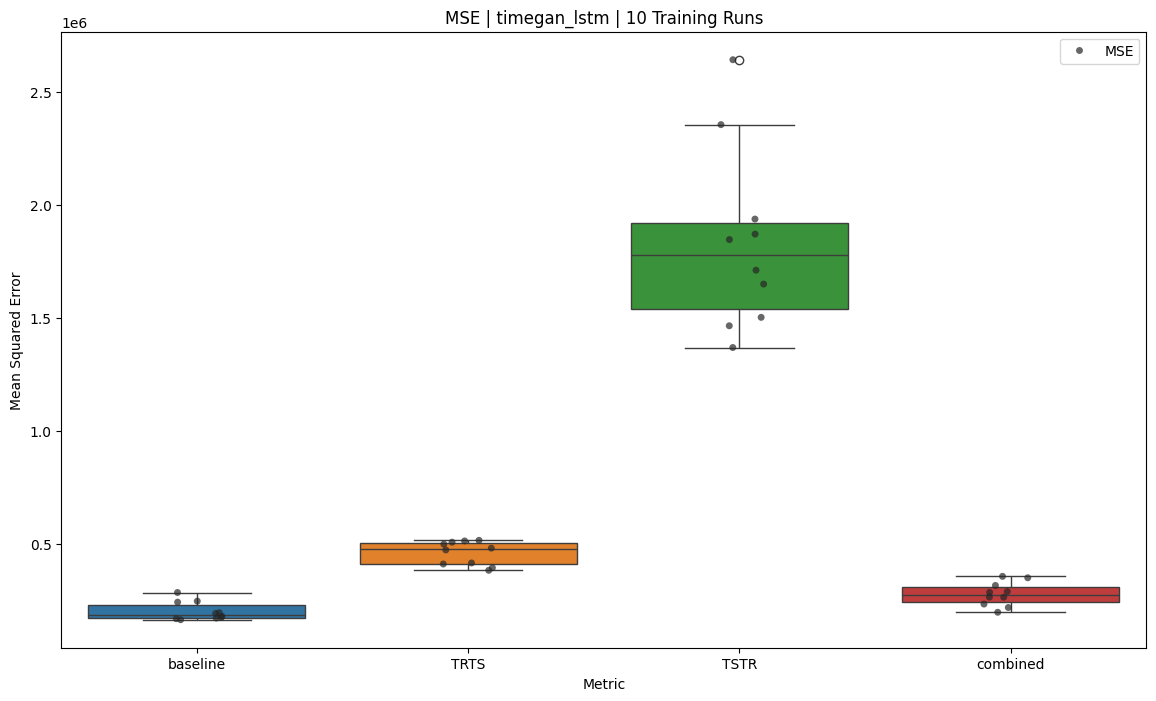

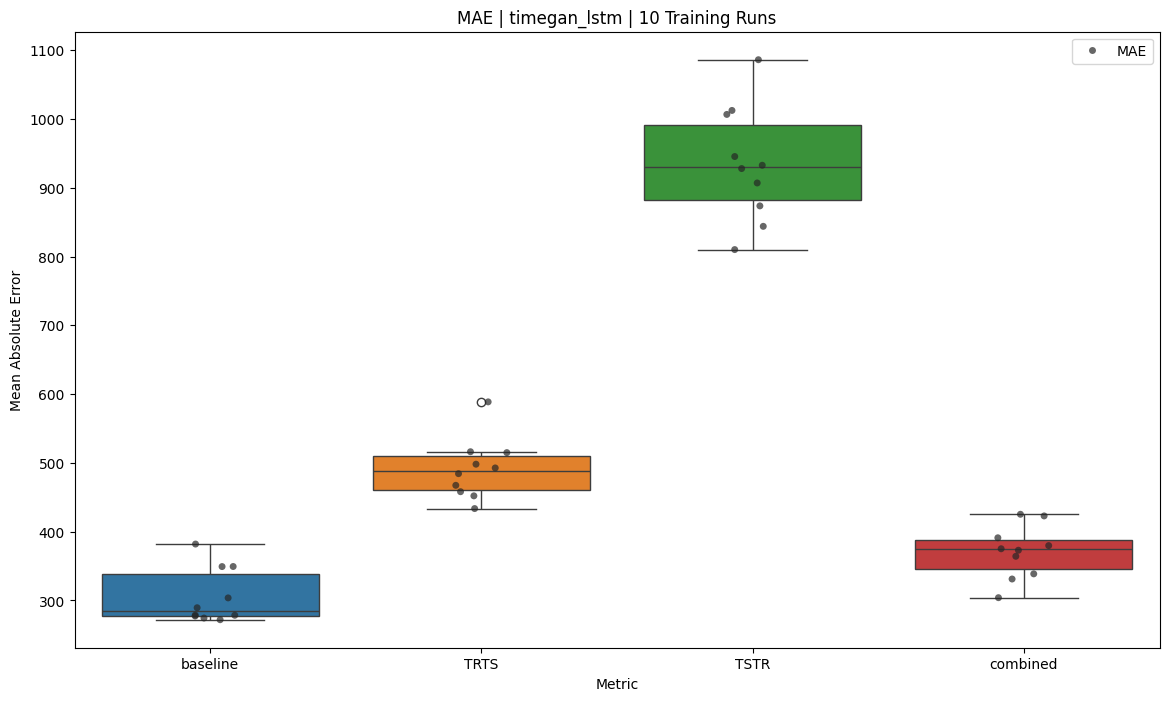

In [8]:
# plot results
plt.figure(figsize=(14, 8))
sns.boxplot(x='Model', y='Error', hue='Model', data=mse_results)
sns.stripplot(x='Model', y='Error', hue='Metric', data=mse_results, dodge=True, jitter=True, palette='dark:black', alpha=0.7)
plt.ylabel('Mean Squared Error')
plt.xlabel('Metric')
plt.title(f'MSE | {syn_data_type} | {hyperparameters["num_evaluation_runs"]} Training Runs')
plt.legend()

plt.figure(figsize=(14, 8))
sns.boxplot(x='Model', y='Error', hue='Model', data=mae_results)
sns.stripplot(x='Model', y='Error', hue='Metric', data=mae_results, dodge=True, jitter=True, palette='dark:black', alpha=0.7)
plt.ylabel('Mean Absolute Error')
plt.xlabel('Metric')
plt.title(f'MAE | {syn_data_type} | {hyperparameters["num_evaluation_runs"]} Training Runs')
plt.legend()

In [9]:
0.2*1e06

200000.0